<a href="https://colab.research.google.com/github/itc202/praktik/blob/main/Grad_CAM_%D1%81_%D0%B3%D0%BB%D0%BE%D0%B1%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%BC_%D0%BF%D1%83%D0%BB%D0%B8%D0%BD%D0%B3%D0%BE%D0%BC_GAP_%D0%B2%D0%B8%D0%B7%D1%83%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BF%D0%BB%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BA%D0%B0%D1%80%D1%82%D1%8B_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Grad-CAM с использованием весов GAP**:
в данном случае не обязательно использовать поиск градиентов для построения карты активации (heatmap), если в модели используется Global Average Pooling (GAP) и есть веса между последним сверточным слоем и выходным плотным слоем. Вы можете использовать эти веса напрямую для вычисления карты активации.
**Почему это возможно?**
Global Average Pooling (GAP) преобразует каждый канал выходного тензора последнего сверточного слоя в одно значение (среднее значение активаций по пространственным измерениям). Эти значения затем передаются в плотный слой, где они умножаются на веса, соответствующие каждому классу. Таким образом, веса между последним сверточным слоем и выходным слоем уже содержат информацию о важности каждого канала для конкретного класса.
*Иное объяснение*: дело в том что в GradCAM вычисляются вектор градиентов, который есть вектор частных производных по координатам, показывающий значимость их для своего класса. При использовании в GAP линейной активации между этими слоями веса между ними как раз и будут результатами взятия этих частныых производстных.Так что применение GAP с одним на выходе слоем классифицирующим слоем dense все упрощает.

**Как это работает?**
Для построения карты активации (heatmap) можно:
Взять веса, соединяющие последний сверточный слой с выходным слоем (softmax).
Умножить эти веса на активации соответствующих каналов последнего сверточного слоя.
Суммировать взвешенные активации по всем каналам, чтобы получить карту активации для конкретного класса.

In [1]:
# Импорт необходимых библиотек
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import random

 Загрузка и подготовка данных CIFAR-10

In [2]:
# Загрузка датасета CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Нормализация данных (приведение значений пикселей к диапазону [0, 1])
x_train, x_test = x_train / 255.0, x_test / 255.0

# Преобразование меток в one-hot encoding
y_train, y_test = to_categorical(y_train), to_categorical(y_test)

# Вывод информации о данных
print(f"Размер тренировочного набора: {x_train.shape}")
print(f"Размер тестового набора: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Размер тренировочного набора: (50000, 32, 32, 3)
Размер тестового набора: (10000, 32, 32, 3)


 Определение и обучение нейросети

In [3]:
# Определение сверточной нейросети
def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.GlobalAveragePooling2D(),  # Global Average Pooling
        layers.Dense(10, activation='softmax')  # Выходной слой для 10 классов
    ])
    return model

# Создание модели
model = create_model()

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# Обучение модели
history = model.fit(x_train, y_train, epochs=1, batch_size=64, validation_data=(x_test, y_test))

782/782 ━━━━━━━━━━━━━━━━━━━━ 65s 81ms/step - accuracy: 0.2863 - loss: 1.8936 - val_accuracy: 0.4337 - val_loss: 1.5472


Функция для визуализации тепловой карты (heatmap)

In [6]:
# Функция для построения тепловой карты (heatmap) с использованием весов GAP
def grad_cam_with_weights(model, img, class_idx):
    # Получаем выход последнего сверточного слоя
    last_conv_layer = model.get_layer(index=-3)  # Последний сверточный слой
    conv_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output])
    conv_outputs = conv_model(np.expand_dims(img, axis=0))[0]  # Активации сверточного слоя

    # Получаем веса между GAP и выходным слоем
    dense_weights = model.layers[-1].weights[0].numpy()  # Веса из Dense слоя (shape: [num_channels, num_classes])

    # Берем веса для конкретного класса
    class_weights = dense_weights[:, class_idx]

    # Умножаем активации каналов на соответствующие веса
    heatmap = np.dot(conv_outputs, class_weights)

    # Нормализуем heatmap
    heatmap = np.maximum(heatmap, 0)  # Убираем отрицательные значения
    heatmap /= np.max(heatmap)  # Нормализация
    return heatmap

# Функция для визуализации тепловой карты
def visualize_heatmap(img, heatmap):
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Наложение heatmap поверх изображения
    plt.axis('off')
    plt.show()

Применение функции визуализации тепловой карты

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
True Label: 2, Predicted Class: 4


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


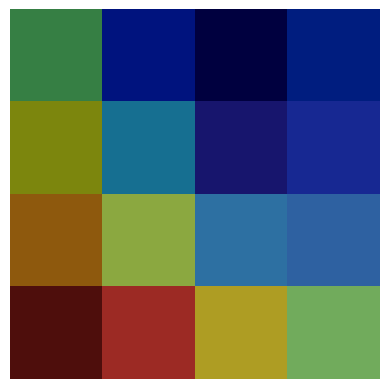

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
True Label: 9, Predicted Class: 9


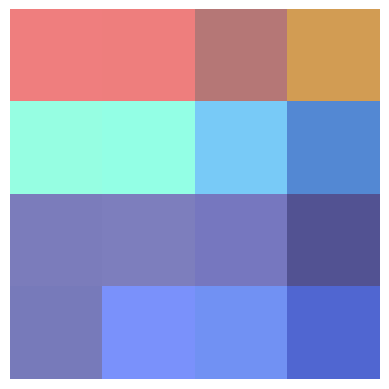

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
True Label: 1, Predicted Class: 1


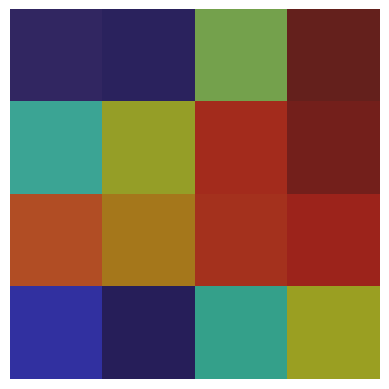

In [7]:
# Вывод 3 случайных изображений из тестового набора с тепловыми картами
for _ in range(3):
    # Случайный выбор изображения из тестового набора
    idx = random.randint(0, len(x_test) - 1)
    sample_img = x_test[idx]
    true_label = np.argmax(y_test[idx])

    # Предсказание класса
    predicted_class = np.argmax(model.predict(np.expand_dims(sample_img, axis=0)))

    # Построение тепловой карты
    heatmap = grad_cam_with_weights(model, sample_img, predicted_class)

    # Визуализация изображения и тепловой карты
    print(f"True Label: {true_label}, Predicted Class: {predicted_class}")
    visualize_heatmap(sample_img, heatmap)

In [9]:
import cv2

Наложение тепловой карты на изображение

In [11]:
# Функция для наложения тепловой карты на изображение
def overlay_heatmap_on_image(img, heatmap, alpha=0.5):
    # Преобразуем тепловую карту в цветное изображение
    heatmap_colored = plt.cm.jet(heatmap)[:, :, :3]  # Убираем альфа-канал
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)  # Преобразуем в формат uint8

    # Масштабируем изображение в диапазон [0, 255]
    img_scaled = (img * 255).astype(np.uint8)

    # Наложение тепловой карты на изображение
    overlay = cv2.addWeighted(img_scaled, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

In [13]:
# Функция для наложения тепловой карты на изображение
def overlay_heatmap_on_image(img, heatmap, alpha=0.5):
    # Масштабируем тепловую карту к размеру изображения
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Преобразуем тепловую карту в цветное изображение (RGB)
    heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]  # Убираем альфа-канал
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)  # Преобразуем в uint8

    # Масштабируем изображение в диапазон [0, 255]
    img_scaled = (img * 255).astype(np.uint8)

    # Наложение тепловой карты на изображение
    overlay = cv2.addWeighted(img_scaled, 1 - alpha, heatmap_colored, alpha, 0)
    return overlay

Применение функции визуализации тепловой карты

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True Label: 1, Predicted Class: 1


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 32, 32, 3))
  warnings.warn(msg)


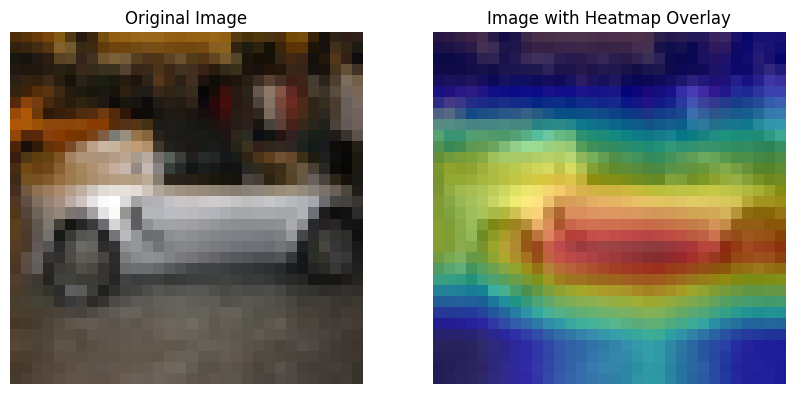

True Label: 1, Predicted Class: 1


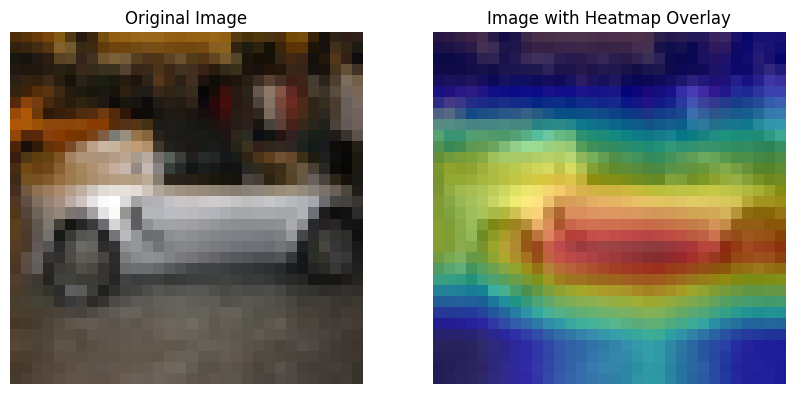

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
True Label: 4, Predicted Class: 1


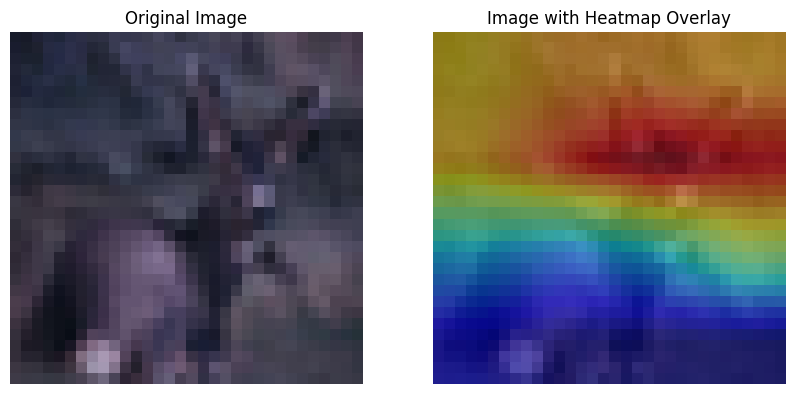

True Label: 4, Predicted Class: 1


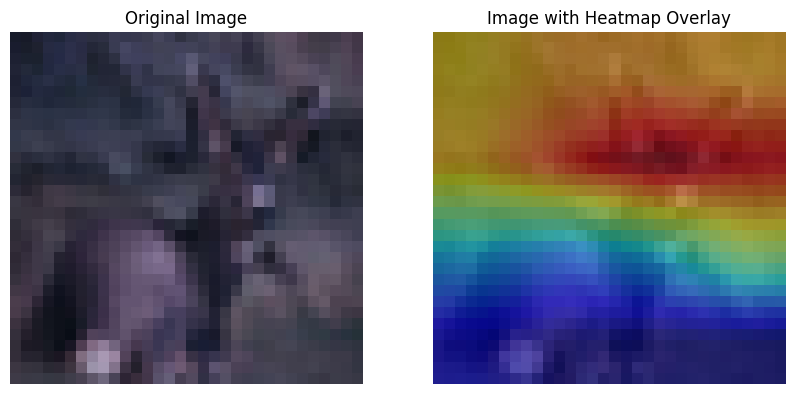

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True Label: 9, Predicted Class: 9


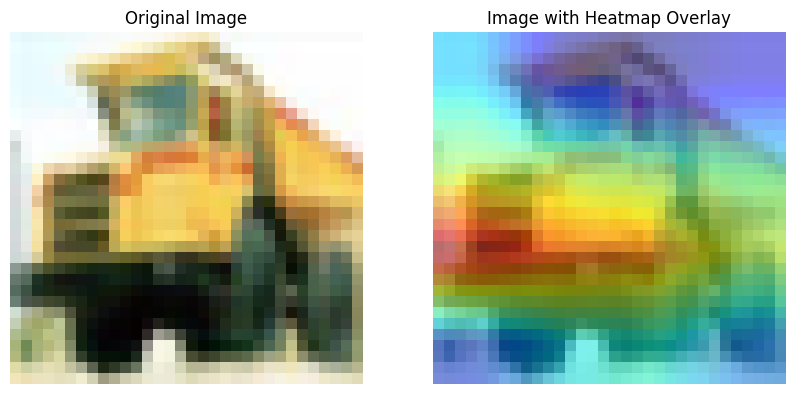

True Label: 9, Predicted Class: 9


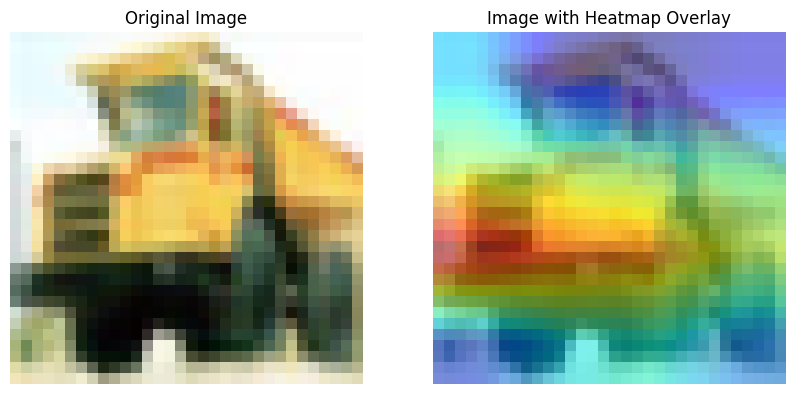

'\n      # Визуализация\n    print(f"True Label: {true_label}, Predicted Class: {predicted_class}")\n    \n    # Устанавливаем DPI для улучшения качества изображения\n    plt.figure(figsize=(5, 5), dpi=200)\n\n    # Оригинальное изображение\n    plt.subplot(1, 2, 1)\n    plt.title("Original Image")\n    plt.imshow(sample_img)\n    plt.axis(\'off\')\n\n    # Изображение с наложенной тепловой картой\n    plt.subplot(1, 2, 2)\n    plt.title("Image with Heatmap Overlay")\n    plt.imshow(overlay)\n    plt.axis(\'off\')\n\n    plt.tight_layout()\n    plt.show()\n'

In [31]:
# Пример использования функции наложения
for _ in range(3):
    # Случайный выбор изображения из тестового набора
    idx = random.randint(0, len(x_test) - 1)
    sample_img = x_test[idx]
    true_label = np.argmax(y_test[idx])

    # Предсказание класса
    predicted_class = np.argmax(model.predict(np.expand_dims(sample_img, axis=0)))

    # Построение тепловой карты
    heatmap = grad_cam_with_weights(model, sample_img, predicted_class)

    # Наложение тепловой карты на изображение
    overlay = overlay_heatmap_on_image(sample_img, heatmap)

    #Ниже смотри визуализацию в другом масштабе

    # Визуализация
    print(f"True Label: {true_label}, Predicted Class: {predicted_class}")
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sample_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Image with Heatmap Overlay")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()


    # Визуализация
    print(f"True Label: {true_label}, Predicted Class: {predicted_class}")
    plt.figure(figsize=(10, 5))

    # Оригинальное изображение
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sample_img)
    #plt.axis('scaled')  # Сохраняем реальный масштаб
    plt.axis('off')

    # Изображение с наложенной тепловой картой
    plt.subplot(1, 2, 2)
    plt.title("Image with Heatmap Overlay")
    plt.imshow(overlay)
    #plt.axis('scaled')  # Сохраняем реальный масштаб
    plt.axis('off')

    plt.show()

"""
      # Визуализация
    print(f"True Label: {true_label}, Predicted Class: {predicted_class}")

    # Устанавливаем DPI для улучшения качества изображения
    plt.figure(figsize=(5, 5), dpi=200)

    # Оригинальное изображение
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sample_img)
    plt.axis('off')

    # Изображение с наложенной тепловой картой
    plt.subplot(1, 2, 2)
    plt.title("Image with Heatmap Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
"""


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
True Label: 0, Predicted Class: 0


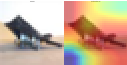

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
True Label: 8, Predicted Class: 8


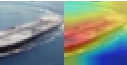

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
True Label: 6, Predicted Class: 1


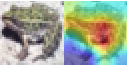

In [32]:
# Пример использования функции наложения
for _ in range(3):
    # Случайный выбор изображения из тестового набора
    idx = random.randint(0, len(x_test) - 1)
    sample_img = x_test[idx]
    true_label = np.argmax(y_test[idx])

    # Предсказание класса
    predicted_class = np.argmax(model.predict(np.expand_dims(sample_img, axis=0)))

    # Построение тепловой карты
    heatmap = grad_cam_with_weights(model, sample_img, predicted_class)

    # Наложение тепловой карты на изображение
    overlay = overlay_heatmap_on_image(sample_img, heatmap)

    # Визуализация
    print(f"True Label: {true_label}, Predicted Class: {predicted_class}")

    # Устанавливаем размер графика 32x32 пикселя
    plt.figure(figsize=(32, 32), dpi=4)  # Размер в дюймах: 32px / 100dpi = 0.32 дюйма

    # Оригинальное изображение
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(sample_img)
    plt.axis('off')

    # Изображение с наложенной тепловой картой
    plt.subplot(1, 2, 2)
    plt.title("Image with Heatmap Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

**Объяснение кода:**
Импорт библиотек:
TensorFlow используется для создания и обучения модели.
Matplotlib используется для визуализации тепловых карт.
Загрузка данных:
CIFAR-10 — это набор данных с 10 классами изображений размером 32x32.
Данные нормализуются, а метки преобразуются в формат one-hot encoding.
Определение модели:
Модель включает три сверточных слоя с активацией ReLU и слоями MaxPooling2D.
В конце используется Global Average Pooling (GAP) и полносвязный слой с softmax для классификации.
**Grad-CAM с использованием весов GAP**:
Карта активации строится с использованием весов между GAP и выходным слоем.
Активации сверточного слоя умножаются на соответствующие веса, чтобы получить тепловую карту.
Визуализация:
Для каждого изображения тепловая карта накладывается на оригинальное изображение с использованием цветовой карты jet.